# Audio Preprocessing

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from scipy.io import wavfile
from scipy import signal

FRAME_SIZE = 2048
HOP_SIZE = 512

In [2]:
audio_files = os.listdir('ESC-50/audio')
audio_list = []
for file in audio_files:
    sample, data = wavfile.read('ESC-50/audio/' + file)
    data = data.astype(np.float32)
    audio_list.append((sample, data))
    print(file)

1-100032-A-0.wav
1-100038-A-14.wav
1-100210-A-36.wav
1-100210-B-36.wav
1-101296-A-19.wav
1-101296-B-19.wav
1-101336-A-30.wav
1-101404-A-34.wav
1-103298-A-9.wav
1-103995-A-30.wav
1-103999-A-30.wav
1-104089-A-22.wav
1-104089-B-22.wav
1-105224-A-22.wav
1-110389-A-0.wav
1-110537-A-22.wav
1-115521-A-19.wav
1-115545-A-48.wav
1-115545-B-48.wav
1-115545-C-48.wav
1-115546-A-48.wav
1-115920-A-22.wav
1-115920-B-22.wav
1-115921-A-22.wav
1-116765-A-41.wav
1-11687-A-47.wav
1-118206-A-31.wav
1-118559-A-17.wav
1-119125-A-45.wav
1-121951-A-8.wav
1-12653-A-15.wav
1-12654-A-15.wav
1-12654-B-15.wav
1-13571-A-46.wav
1-13572-A-46.wav
1-13613-A-37.wav
1-137-A-32.wav
1-137296-A-16.wav
1-14262-A-37.wav
1-155858-A-25.wav
1-155858-B-25.wav
1-155858-C-25.wav
1-155858-D-25.wav
1-155858-E-25.wav
1-155858-F-25.wav
1-15689-A-4.wav
1-15689-B-4.wav
1-160563-A-48.wav
1-160563-B-48.wav
1-16568-A-3.wav
1-16746-A-15.wav
1-17092-A-27.wav
1-17092-B-27.wav
1-17124-A-43.wav
1-17150-A-12.wav
1-172649-A-40.wav
1-172649-B-40.wav


KeyboardInterrupt: 

## Esempio preprocessing singolo audio

In [3]:
single_audio_test = audio_list[0][1]

Creazione di una window di Hann di ampiezza uguale a quella del frame.
$$
w(n) = 0.5 \left( 1 - \cos \left( \frac{2\pi n}{N-1} \right) \right), \quad 0 \leq n \leq N-1
$$

dove:
- n è l'indice del campione,
- N è la lunghezza della finestra.

La larghezza della finestra è stata posta uguale a quella del frame in modo da non avere valori del segnale audio ignorati.

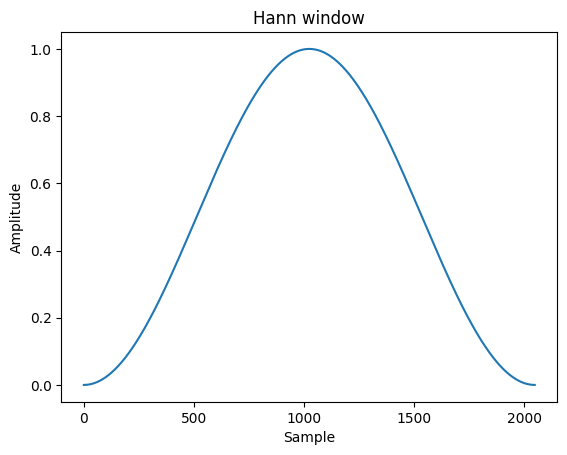

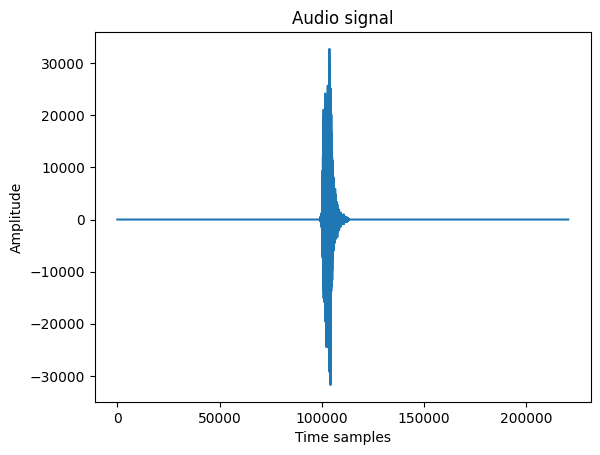

In [4]:
hann_win = signal.windows.hann(FRAME_SIZE) 
plt.plot(hann_win)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

plt.plot(single_audio_test)
plt.title("Audio signal")
plt.ylabel("Amplitude")
plt.xlabel("Time samples")
plt.show()

Normalizzazione dei valori del segnale prima della trasformata con le tecniche di:
* Min-max [-1; 1]: $$x' = 2 \times \frac{x - x_{\min}}{x_{\max} - x_{\min}} - 1$$
* Z-score: $$x' = \frac{x - \mu}{\sigma}$$

In [5]:
# normalizzazione segnale min-max tra -1 e 1 
def min_max(data):
    max_val = np.max(data)
    min_val = np.min(data)
    denom = max_val - min_val if max_val != min_val else 1
    return (2*(data - min_val)/(denom))-1

# normalizzazione segnale z-score
def z_score(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std

In [6]:
single_audio_norm_mm = min_max(single_audio_test)
single_audio_norm_z = z_score(single_audio_test)

Plot del grafico di una porzione del segnale significativa con applicata la finestra di Hann shiftata di HOP_SIZE

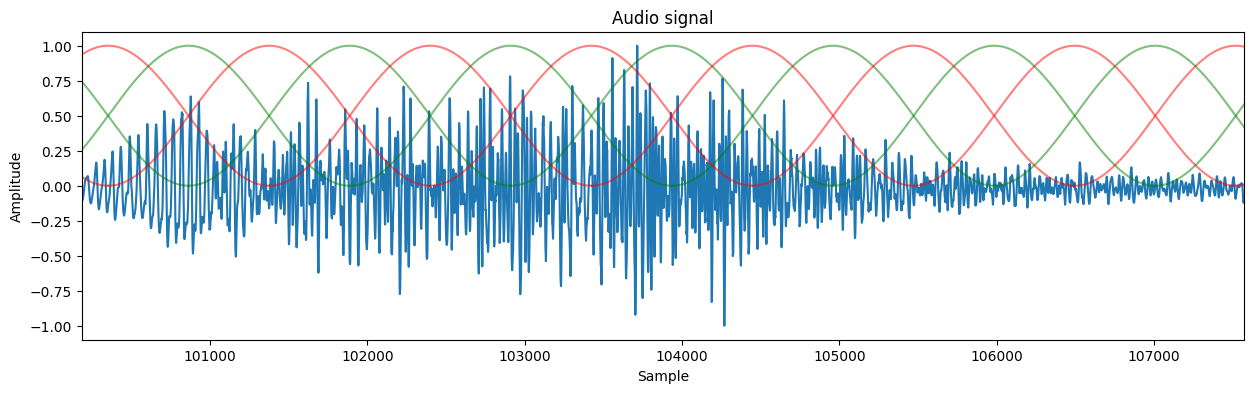

In [7]:
plt.figure(figsize=(15, 4))  
plt.plot(single_audio_norm_mm)
plot_start = np.argmax(abs(single_audio_norm_mm) > 0.1)
plot_end = len(single_audio_norm_mm) - np.argmax(abs(single_audio_norm_mm[::-1]) > 0.1)
plt.xlim(plot_start, plot_end)
plt.title("Audio signal")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
i=0
colors = ['red', 'green']
for start in range(0, len(single_audio_norm_mm) - FRAME_SIZE, HOP_SIZE):
    curr_color = colors[i % 2]
    i += 1
    plt.plot(range(start, start + FRAME_SIZE), hann_win, color=curr_color, alpha=0.5)
plt.show()

Calcolo dei valori della short time fourier transform andando ad applicare la finestra di Hann definita in precedenza.

In [8]:
SFT = signal.ShortTimeFFT(hann_win, hop=HOP_SIZE, fs=FRAME_SIZE)
s_x = SFT.stft(single_audio_norm_mm)

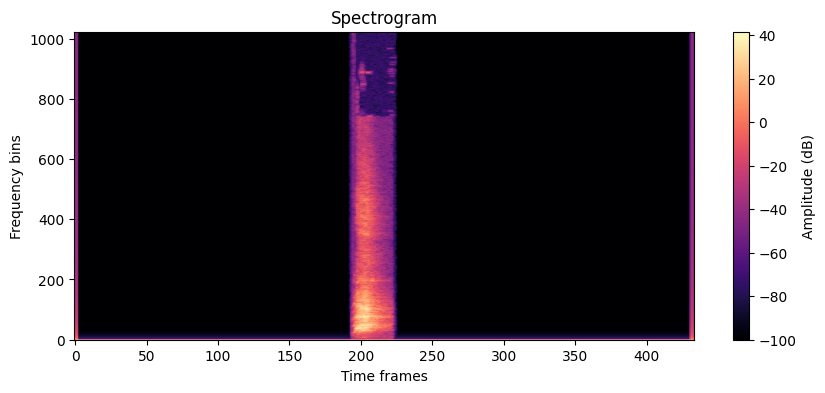

In [9]:
spectrogram = np.abs(s_x)**2
spectrogram_db = 10 * np.log10(spectrogram + 1e-10)

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_db, aspect='auto', origin='lower', cmap='magma')

plt.colorbar(label="Amplitude (dB)")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.title("Spectrogram")

plt.show()

## Pipeline classificazione audio

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from pathlib import Path

In [11]:
def preprocessing(data):
    # definizione della finestra di Hann
    hann_win = signal.windows.hann(FRAME_SIZE)

    # normalizzazione segnale min-max tra -1 e 1
    max_val = np.max(data)
    min_val = np.min(data)
    denom = max_val - min_val if max_val != min_val else 1e-10
    data_norm = (2*(data - min_val)/(denom))-1

    # calcolo dell'STF
    SFT = signal.ShortTimeFFT(hann_win, hop=HOP_SIZE, fs=FRAME_SIZE)
    s_x = SFT.stft(data_norm)

    # calcolo valori per lo spettrogramma, viene ritornata la versione logaritmica dei valori
    spectrogram = np.abs(s_x)**2
    return 10 * np.log10(spectrogram + 1e-10)

In [15]:
class_df = pd.read_csv('ESC-50/esc50.csv')
class_df = class_df.drop(columns=['fold', 'esc10', 'src_file', 'take'])
classes = class_df['target'].unique().astype(str)

audio_files = os.listdir('ESC-50/audio')
output_dir = Path("spectrograms")

for category in classes:
    category_dir = output_dir / category
    category_dir.mkdir(parents=True, exist_ok=True)

i = 1
matplotlib.use('Agg')
fig, ax = plt.subplots(figsize=(10, 4))

for file in audio_files:
    sample, data = wavfile.read(f'ESC-50/audio/{file}')
    data = data.astype(np.float32)
    curr_spec = preprocessing(data)

    ax.clear()
    im = ax.imshow(curr_spec, aspect='auto', origin='lower', cmap='magma')

    file_path = Path(file).stem 
    category = file_path.split('-')[-1]
    filename = file_path + ".png" 
    category_dir = output_dir / category

    fig.savefig(category_dir / filename, bbox_inches='tight')

    print(f"processata immagine: {i} di {len(audio_files)}")
    i += 1

plt.close(fig)



processata immagine: 1 di 2000
processata immagine: 2 di 2000
processata immagine: 3 di 2000
processata immagine: 4 di 2000
processata immagine: 5 di 2000
processata immagine: 6 di 2000
processata immagine: 7 di 2000
processata immagine: 8 di 2000
processata immagine: 9 di 2000
processata immagine: 10 di 2000
processata immagine: 11 di 2000
processata immagine: 12 di 2000
processata immagine: 13 di 2000
processata immagine: 14 di 2000
processata immagine: 15 di 2000
processata immagine: 16 di 2000
processata immagine: 17 di 2000
processata immagine: 18 di 2000
processata immagine: 19 di 2000
processata immagine: 20 di 2000
processata immagine: 21 di 2000
processata immagine: 22 di 2000
processata immagine: 23 di 2000
processata immagine: 24 di 2000
processata immagine: 25 di 2000
processata immagine: 26 di 2000
processata immagine: 27 di 2000
processata immagine: 28 di 2000
processata immagine: 29 di 2000
processata immagine: 30 di 2000
processata immagine: 31 di 2000
processata immagi

In [13]:
# contare gli elementi prensenti nelle sottocartelle di spectrograms
num_files = 0
for c in classes:
    num_files = len(os.listdir('spectrograms/' + str(c)))
    if num_files != 0:
        print(f"Numero di immagini nella cartella {c}: {num_files}")

Numero di immagini nella cartella 0: 40
Numero di immagini nella cartella 14: 40
Numero di immagini nella cartella 36: 40
Numero di immagini nella cartella 19: 40
Numero di immagini nella cartella 30: 40
Numero di immagini nella cartella 34: 40
Numero di immagini nella cartella 9: 40
Numero di immagini nella cartella 22: 40
Numero di immagini nella cartella 48: 40
Numero di immagini nella cartella 41: 40
Numero di immagini nella cartella 47: 40
Numero di immagini nella cartella 31: 40
Numero di immagini nella cartella 17: 40
Numero di immagini nella cartella 45: 40
Numero di immagini nella cartella 8: 40
Numero di immagini nella cartella 15: 40
Numero di immagini nella cartella 46: 40
Numero di immagini nella cartella 37: 40
Numero di immagini nella cartella 32: 40
Numero di immagini nella cartella 16: 40
Numero di immagini nella cartella 25: 40
Numero di immagini nella cartella 4: 40
Numero di immagini nella cartella 3: 40
Numero di immagini nella cartella 27: 40
Numero di immagini ne